# STAR polarimetry simulation
Simulation of proton-proton (pp) and proton-carbon (pC) collisions with a proton kinetic energy of 100 GeV hitting a target particle at rest.

- Incident proton: 100 GeV kinetic energy

- Target particle: at rest (either proton or carbon nucleus)

- Calculate scattering angles and recoil energies of the target in the lab and CM frames

In [32]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

# Importing necessary libraries
import pandas as pd
import math
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Generating CNI protons

In [33]:
# Constants
mp = 0.938  # GeV/c², proton mass
mC = 12 * mp  # GeV/c², carbon-12 nucleus

# Settings
T_lab = 100  # GeV kinetic energy
target_type = 'p'  # 'p' or 'C'
#n_events = 50_000_000
n_events = 5_000_000

# Mass assignment
m1 = mp
m2 = mp if target_type == 'p' else mC

# Lab frame initial energy and momentum
E1_lab = T_lab + m1
p1_lab = np.sqrt(E1_lab**2 - m1**2)

# Invariant mass and CM motion
s = m1**2 + m2**2 + 2 * m2 * E1_lab
E_cm = np.sqrt(s)
beta_cm = p1_lab / (E1_lab + m2)
gamma_cm = 1 / np.sqrt(1 - beta_cm**2)

# Momentum in CM frame
p_cm = np.sqrt((s - (m1 + m2)**2) * (s - (m1 - m2)**2)) / (2 * E_cm)
E1_cm = np.sqrt(p_cm**2 + m1**2)
E2_cm = np.sqrt(p_cm**2 + m2**2)

# Generate random CM scattering angles
cos_theta_cm = 2 * np.random.rand(n_events) - 1
theta_cm1 = np.arccos(cos_theta_cm)
theta_cm2 = np.pi - theta_cm1
phi = 2 * np.pi * np.random.rand(n_events)

# CM momentum components (particle 1)
px_cm = p_cm * np.sin(theta_cm1) * np.cos(phi)
py_cm = p_cm * np.sin(theta_cm1) * np.sin(phi)
pz_cm = p_cm * np.cos(theta_cm1)

# Boost to lab frame (z-axis only)
pz_lab = gamma_cm * (pz_cm + beta_cm * E1_cm)
E1_lab_final = gamma_cm * (E1_cm + beta_cm * pz_cm)
T1_lab_final = E1_lab_final - m1

# Lab angles
theta1_lab = np.arctan2(np.sqrt(px_cm**2 + py_cm**2), pz_lab)
phi1_lab = np.arctan2(py_cm, px_cm)

# Recoil target (particle 2) momentum in CM
px2_cm = -px_cm
py2_cm = -py_cm
pz2_cm = -pz_cm

# Boost target to lab
pz2_lab = gamma_cm * (pz2_cm + beta_cm * E2_cm)
E2_lab_final = gamma_cm * (E2_cm + beta_cm * pz2_cm)
T2_lab_final = E2_lab_final - m2
theta2_lab = np.arctan2(np.sqrt(px2_cm**2 + py2_cm**2), pz2_lab)
phi2_lab = np.arctan2(py2_cm, px2_cm)

# Unit direction vector in lab frame
ux = np.sin(theta2_lab) * np.cos(phi2_lab)
uy = np.sin(theta2_lab) * np.sin(phi2_lab)
uz = np.cos(theta2_lab)

R = 10.0  # cm

x = R * ux
y = R * uy
z = R * uz

# Mandelstam t
t = -2 * m1**2 + 2 * (E1_lab * E1_lab_final - p1_lab * pz_lab)




## Calculating A<sub>N</sub>

In [34]:
# A_N(t)calculation
def A_N_model(t):
    # A_N calculation for H elastic scattering in CNI region
    G=1.7928
    alpha = 1/137.03
    mb_to_GeV = 2.568 #GeV**-2
    # Hidrogen (p)
    Z = 1
    sig_tot = 35 * mb_to_GeV #mb

    t0=8*math.pi*alpha*Z/sig_tot

    A_N=G*t0*t*np.sqrt(t) / (mp*(t**2+t0**2)) 

    # weight for polarized beam    
    return A_N


Set CM with t < 0.1 GeV^2

In [35]:
A_N = A_N_model(t)
selection = t < 0.01000
selection_1 = (t >= 0.1) & (t<1)
selection_2 = (t >= 1) & (t<1e3)

## Lab-frame plots

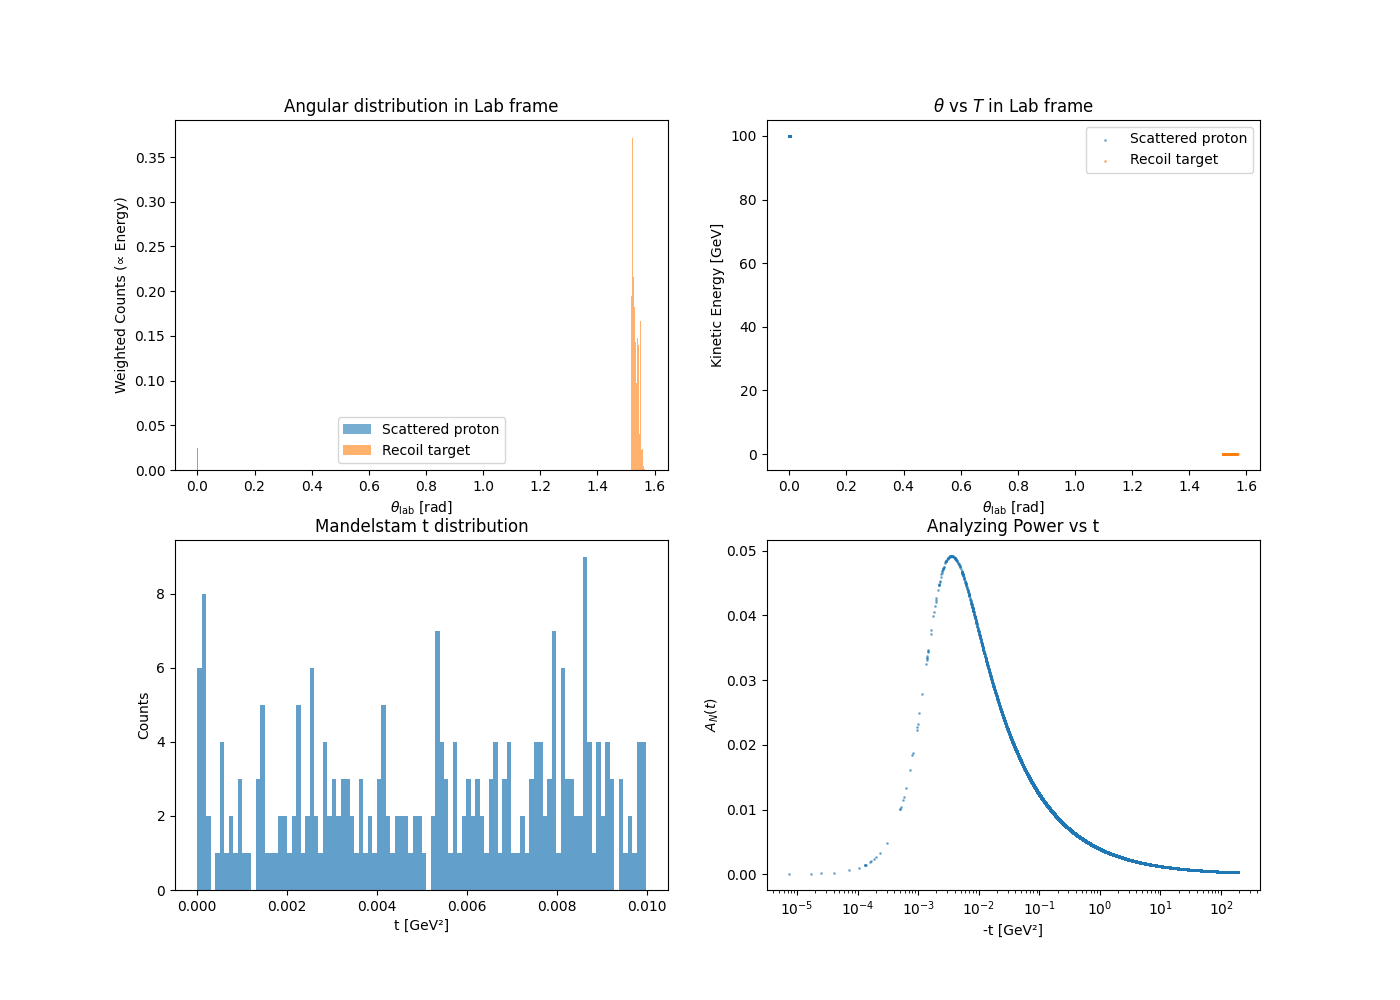

In [36]:
# --- PLOTS ---

import matplotlib.pyplot as plt

# Create first figure: LAB frame plots
fig1, axs1 = plt.subplots(2, 2, figsize=(14, 10))


# 1. Angular distribution (lab)
axs1[0, 0].hist(theta1_lab[selection], bins=100, weights=A_N[selection], alpha=0.6, label='Scattered proton')
axs1[0, 0].hist(theta2_lab[selection], bins=100, weights=A_N[selection], alpha=0.6, label='Recoil target')
axs1[0, 0].set_xlabel(r'$\theta_{\mathrm{lab}}$ [rad]')
axs1[0, 0].set_ylabel('Weighted Counts (∝ Energy)')
axs1[0, 0].set_title('Angular distribution in Lab frame')
axs1[0, 0].legend()

# 2. Energy vs angle
axs1[0, 1].scatter(theta1_lab[selection], T1_lab_final[selection], s=1, alpha=0.5, label='Scattered proton')
axs1[0, 1].scatter(theta2_lab[selection], T2_lab_final[selection], s=1, alpha=0.5, label='Recoil target')
axs1[0, 1].set_xlabel(r'$\theta_{\mathrm{lab}}$ [rad]')
axs1[0, 1].set_ylabel('Kinetic Energy [GeV]')
axs1[0, 1].set_title(r'$\theta$ vs $T$ in Lab frame')
axs1[0, 1].legend()

# 3. Mandelstam t
axs1[1, 0].hist(t[selection], bins=100, alpha=0.7)
axs1[1, 0].set_xlabel('t [GeV²]')
axs1[1, 0].set_ylabel('Counts')
axs1[1, 0].set_title('Mandelstam t distribution')

# 4. A_N(t)
axs1[1, 1].scatter(t, A_N, s=1, alpha=0.5)
axs1[1, 1].set_xlabel('-t [GeV²]')
axs1[1, 1].set_ylabel(r'$A_N(t)$')
axs1[1, 1].set_title('Analyzing Power vs t')
#axs1[1, 1].set_xlim(1e-4, 0.1)
axs1[1, 1].set_xscale('log')

#fig1.tight_layout()
fig1.savefig("lab_frame_plots.png")
plt.show()




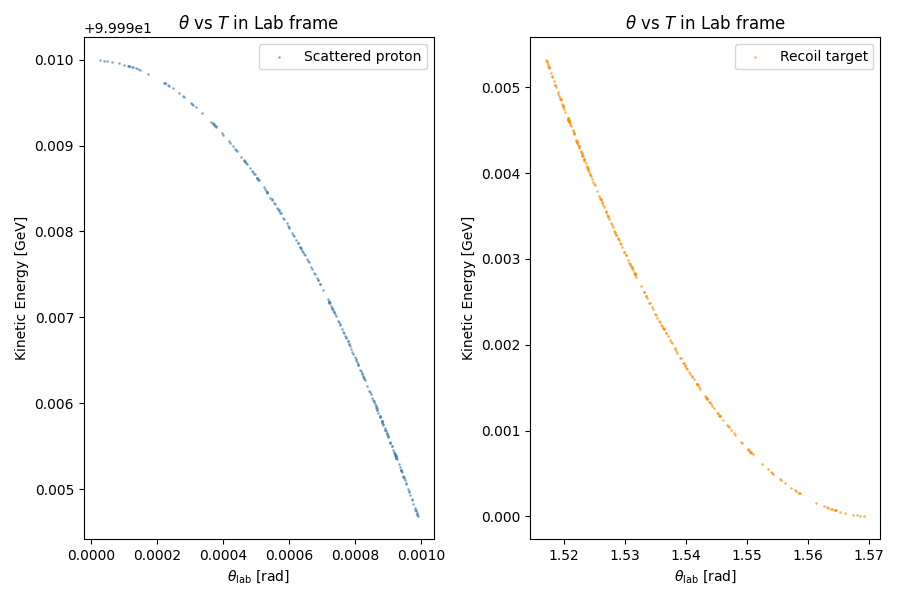

In [37]:
# --- Lab Frame Plots ---
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

ax[0].scatter(theta1_lab[selection], T1_lab_final[selection], s=1, alpha=0.5, label='Scattered proton', color='steelblue')
ax[0].set_xlabel(r'$\theta_{\mathrm{lab}}$ [rad]')
ax[0].set_ylabel('Kinetic Energy [GeV]')
ax[0].set_title(r'$\theta$ vs $T$ in Lab frame')
ax[0].legend()

ax[1].scatter(theta2_lab[selection], T2_lab_final[selection], s=1, alpha=0.5, label='Recoil target', color='darkorange')
ax[1].set_xlabel(r'$\theta_{\mathrm{lab}}$ [rad]')
ax[1].set_ylabel('Kinetic Energy [GeV]')
ax[1].set_title(r'$\theta$ vs $T$ in Lab frame')
ax[1].legend()


fig.tight_layout()
fig.savefig("cm_theta_plots.png")
plt.show()


## CM Frame Plots 

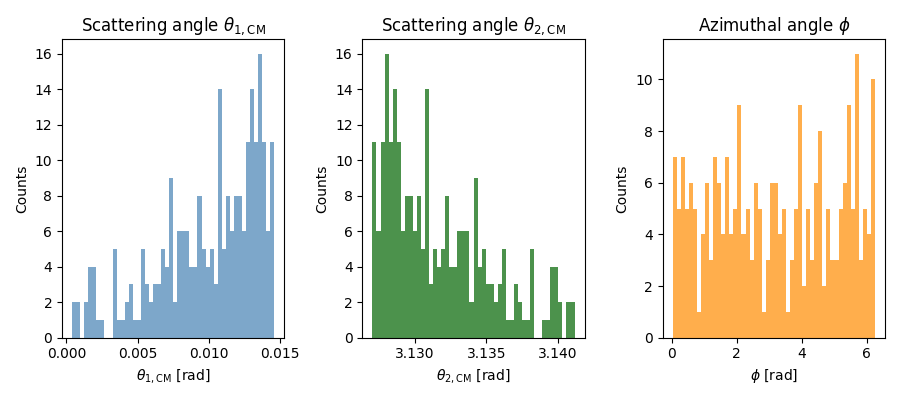

In [38]:
# --- CM Frame Plots ---
fig2, axs2 = plt.subplots(1, 3, figsize=(9, 4))

# 5. θ_cm1 distribution
axs2[0].hist(theta_cm1[selection], bins=50, alpha=0.7, color='steelblue')
axs2[0].set_xlabel(r'$\theta_{1,\mathrm{CM}}$ [rad]')
axs2[0].set_ylabel('Counts')
axs2[0].set_title(r'Scattering angle $\theta_{1,\mathrm{CM}}$')

# 6. θ_cm2 distribution (π - θ1_cm)
axs2[1].hist(theta_cm2[selection], bins=50, alpha=0.7, color='darkgreen')
axs2[1].set_xlabel(r'$\theta_{2,\mathrm{CM}}$ [rad]')
axs2[1].set_ylabel('Counts')
axs2[1].set_title(r'Scattering angle $\theta_{2,\mathrm{CM}}$')

# 7. φ distribution
axs2[2].hist(phi[selection], bins=50, alpha=0.7, color='darkorange')
axs2[2].set_xlabel(r'$\phi$ [rad]')
axs2[2].set_ylabel('Counts')
axs2[2].set_title(r'Azimuthal angle $\phi$')

fig2.tight_layout()
fig2.savefig("cm_frame_plots.png")
plt.show()




In [39]:
x_plane = x[selection]
y_plane = y[selection]
z_plane = z[selection]

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_78505/996224132.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(8, 6))


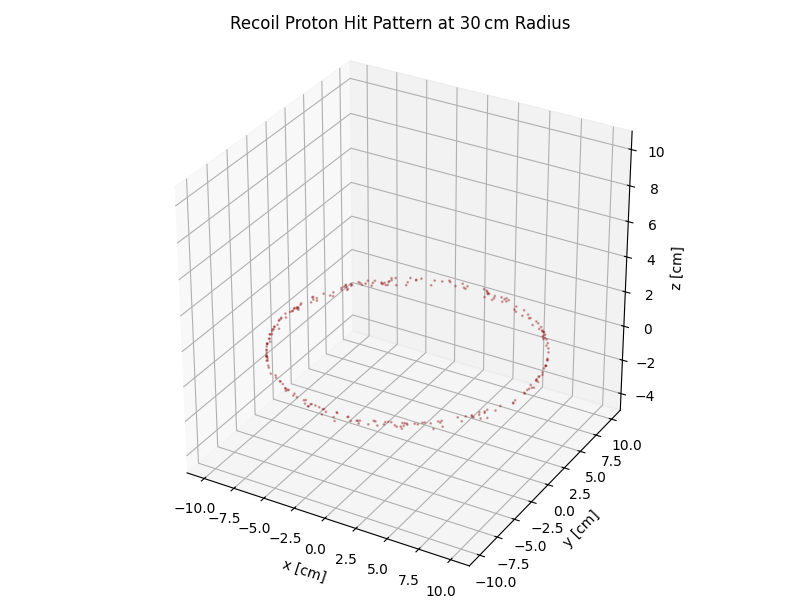

In [40]:
# --- Create 3D plot ---
fig1 = plt.figure(figsize=(8, 6))
axs1 = fig1.add_subplot(111, projection='3d')

axs1.set_zlim(-5, 11)
axs1.scatter(x_plane, y_plane, z_plane, s=1, alpha=0.3, color='darkred')
axs1.set_xlabel("x [cm]")
axs1.set_ylabel("y [cm]")
axs1.set_zlabel("z [cm]")
axs1.set_title("Recoil Proton Hit Pattern at 30 cm Radius")
axs1.set_box_aspect([1,1,1])  # Equal aspect ratio

fig1.tight_layout()
fig1.savefig("recoil_proton_3D_hits.png")
plt.show()

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_78505/436759340.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


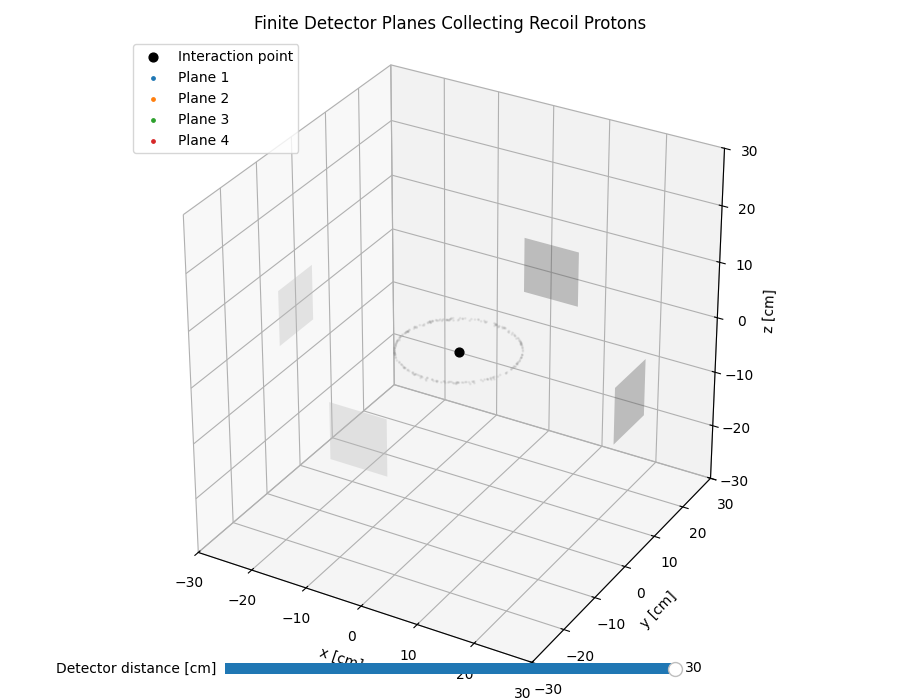

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

AttributeError: 'Axes' object has no attribute 'plot_surface'

In [ ]:
from matplotlib.widgets import Slider


# ---------------- Detector configuration ----------------
angles = np.deg2rad([0, 90, 180, 270])
plane_width  = 10.0   # cm
plane_height = 10.0   # cm
plane_tol    = 0.3  # thickness

collected = [np.zeros(len(x_plane), dtype=bool) for _ in range(4)]


# ---------------- Figure ----------------
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_box_aspect([1,1,1])

ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")
ax.set_title("Finite Detector Planes Collecting Recoil Protons")

# Origin
ax.scatter(0, 0, 0, s=40, c='black', label="Interaction point")

# All particles (faint)
ax.scatter(x_plane, y_plane, z_plane, s=1, alpha=0.1, color='gray')

# Collected hit scatters
hit_scatters = [
    ax.scatter([], [], [], s=6, label=f"Plane {i+1}")
    for i in range(4)
]

# Plane surfaces
plane_surfaces = []

def draw_plane(theta, d):
    n = np.array([np.cos(theta), np.sin(theta), 0])
    u = np.array([-np.sin(theta), np.cos(theta), 0])
    v = np.array([0, 0, 1])

    center = d * n

    uu = np.linspace(-plane_width/2, plane_width/2, 2)
    vv = np.linspace(-plane_height/2, plane_height/2, 2)
    U, V = np.meshgrid(uu, vv)

    X = center[0] + U*u[0] + V*v[0]
    Y = center[1] + U*u[1] + V*v[1]
    Z = center[2] + U*u[2] + V*v[2]

    return X, Y, Z

# ---------------- Slider ----------------
ax_d = plt.axes([0.25, 0.03, 0.5, 0.03])
s_d = Slider(ax_d, "Detector distance [cm]", 5, 30.0, valinit=30.0)

# ---------------- Update ----------------
def update(val):
    global plane_surfaces
    d = s_d.val

    # remove old planes
    for surf in plane_surfaces:
        surf.remove()
    plane_surfaces = []

    for i, theta in enumerate(angles):
        n = np.array([np.cos(theta), np.sin(theta), 0])
        u = np.array([-np.sin(theta), np.cos(theta), 0])

        # distance to plane
        dist = (x_plane*n[0] + y_plane*n[1]) - d

        # intersection condition
        hit_plane = np.abs(dist) < plane_tol

        # in-plane coordinates
        proj_u = x_plane*u[0] + y_plane*u[1]
        proj_v = z_plane

        in_box = (
            np.abs(proj_u) < plane_width/2
        ) & (
            proj_v < plane_height/2
        ) & (
            proj_v > -plane_height/2
        )

        newly_collected = hit_plane & in_box & (~collected[i])
        collected[i] |= newly_collected

        hit_scatters[i]._offsets3d = (
            x_plane[collected[i]],
            y_plane[collected[i]],
            z_plane[collected[i]]
        )

        # draw plane
        Xp, Yp, Zp = draw_plane(theta, d)
        surf = ax.plot_surface(
            Xp, Yp, Zp,
            color='lightgray',
            alpha=0.35,
            linewidth=0
        )
        plane_surfaces.append(surf)

    fig.canvas.draw_idle()

s_d.on_changed(update)
update(None)

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()



In [42]:



from scipy.interpolate import RegularGridInterpolator

def simulate_proton_trajectory(r0, v0, dt=1e-11, steps=10000, use_B=True, stop_radius=0.3):
    q = 1.602e-19      # C
    m = 1.6726e-27     # kg (proton mass)
    
    
    r = np.array(r0, dtype=float)
    v = np.array(v0, dtype=float)

    trajectory = [r.copy()]

    return np.array(trajectory)



# Initial position: origin
r0 = np.array([0.0, 0.0, 0.0])  # m

# Initial direction from theta2_lab and phi2_lab
speed = 1e7  # m/s (adjust based on T2_lab_final)

from mpl_toolkits.mplot3d import Axes3D

delta_end_x = []
delta_end_y = []
delta_end_z = []
end_x = []
end_y = []
end_z = []
end_x_noB = []
end_y_noB = []
end_z_noB = []
# Plot 3D trajectory
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

results = []
i=0
for Theta2_lab, Phi2_lab in zip(theta2_lab[selection],phi2_lab[selection]):
    v0 = speed * np.array([
        np.sin(Theta2_lab) * np.cos(Phi2_lab),
        np.sin(Theta2_lab) * np.sin(Phi2_lab),
        np.cos(Theta2_lab)
    ])

    trajectory       = simulate_proton_trajectory(r0, v0, use_B=True  , stop_radius=0.3)
    trajectory_noB   = simulate_proton_trajectory(r0, v0, use_B=False , stop_radius=0.3)
    #len_trajectory = len(trajectory)
    #len_trajectory_noB = len(trajectory_noB)
    #print(f"Trajectory length with B: {len_trajectory}, without B: {len_trajectory_noB}")
    # Final positions
    r_withB = trajectory[-1]
    r_noB   = trajectory_noB[-1]
    delta = r_withB - r_noB
    delta_end_x.append(delta[0])
    delta_end_y.append(delta[1])
    delta_end_z.append(delta[2])
    
    end_x = r_withB[0]
    end_y = r_withB[1]
    end_z = r_withB[2]
    end_x_noB = r_noB[0]
    end_y_noB = r_noB[1]
    end_z_noB = r_noB[2]    
    

    results.append({
        'T1_lab': T1_lab_final[selection][i],
        'T2_lab': T2_lab_final[selection][i],
        #'trajectory': trajectory,     
        #'trajectory_noB': trajectory_noB, 
        'p_x_withB_cm': r_withB[0] * 100,
        'p_y_withB_cm': r_withB[1] * 100,
        'p_z_withB_cm': r_withB[2] * 100,
        'p_x_noB_cm':   r_noB[0] * 100,
        'p_y_noB_cm':   r_noB[1] * 100,
        'p_z_noB_cm':   r_noB[2] * 100,
        'p_dx_cm':      delta[0] * 100,
        'p_dy_cm':      delta[1] * 100,
        'p_dz_cm':      delta[2] * 100,
        'p_t':    t[selection][i],
        'A_N':    A_N[selection][i],
        'theta2_lab': Theta2_lab, 
        'phi2_lab': Phi2_lab
    })    
    i+=1 
    #print(f"Δx = {delta[0]*100:.2f} cm, Δy = {delta[1]*100:.2f} cm, Δz = {delta[2]*100:.2f} cm")
    #ax.plot(trajectory[:,0]*100, trajectory[:,1]*100, trajectory[:,2]*100)  # m → cm
#ax.set_xlabel('x [cm]')
#ax.set_ylabel('y [cm]')
#ax.set_zlabel('z [cm]')
#ax.set_title('Proton trajectory in magnetic field')
#plt.show()
#for i in range(len(delta_end_x)):

# Create DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv("proton_drift_comparison_RHIC_R30.csv", index=False)
print("Saved to proton_drift_comparison.csv")



Saved to proton_drift_comparison.csv


In [43]:
df    = pd.read_csv("proton_drift_comparison_FieldMap_BX_tgt_orientation_R15.csv")  # Replace with actual filename
df_BY = pd.read_csv("proton_drift_comparison_FieldMap_BY_tgt_orientation_R15.csv")  # Replace with actual filename
df_BZ = pd.read_csv("proton_drift_comparison_FieldMap_BZ_tgt_orientation_R15.csv")  # Replace with actual filename

# Position with magnetic field
x_withB = df['p_x_noB_cm'].values
y_withB = df['p_y_noB_cm'].values
z_withB = df['p_z_noB_cm'].values

x_withBY = df_BY['p_x_noB_cm'].values
y_withBY = df_BY['p_y_noB_cm'].values
z_withBY = df_BY['p_z_noB_cm'].values

x_withBZ = df_BZ['p_x_noB_cm'].values
y_withBZ = df_BZ['p_y_noB_cm'].values
z_withBZ = df_BZ['p_z_noB_cm'].values

# Position without magnetic field
x_noB = df['p_x_noB_cm'].values
y_noB = df['p_y_noB_cm'].values
z_noB = df['p_z_noB_cm'].values

T2_lab = df['T2_lab'].values
theta2_lab = df['theta2_lab'].values
A_N = df['A_N'].values


In [44]:
#fieldMapFileName = 'FieldMap_BX_tgt_orientation'
#fieldMapFileName = 'FieldMap_BY_tgt_orientation'
fieldMapFileName = 'FieldMap_BZ_tgt_orientation'

# Load CSV with magnetic field map
df_B = pd.read_csv(fieldMapFileName+".csv")
print(df_B.head() )
# Extract coordinates and field components
x  = df_B['x_m'].values
y  = df_B['y_m'].values
z  = df_B['z_m'].values
Bx = df_B['Bx_T'].values
By = df_B['By_T'].values
Bz = df_B['Bz_T'].values
B  = df_B['B_mag_T'].values
print(B.max())

   x_m       y_m  z_m      Bx_T      By_T      Bz_T   B_mag_T
0 -0.2 -0.200000 -0.2  0.000738  0.000738  0.001205  0.001594
1 -0.2 -0.194937 -0.2  0.000777  0.000734  0.001282  0.001670
2 -0.2 -0.189873 -0.2  0.000818  0.000726  0.001363  0.001747
3 -0.2 -0.184810 -0.2  0.000859  0.000714  0.001446  0.001827
4 -0.2 -0.179747 -0.2  0.000900  0.000696  0.001531  0.001908
6195.51388328518


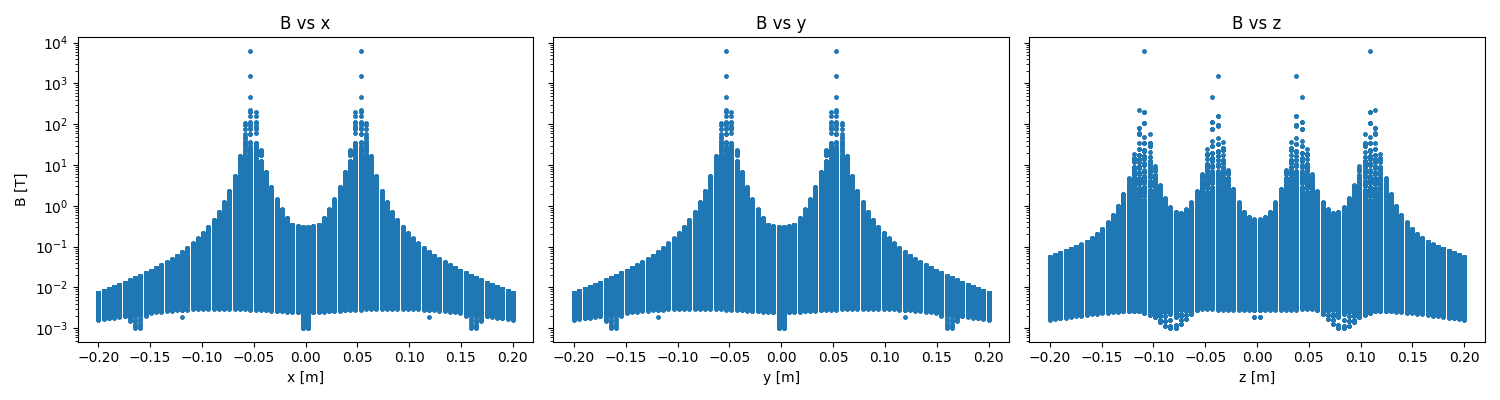

In [45]:
# --- Create 3-panel plot ---
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# 1. B vs x
axs[0].scatter(x, B, s=5, alpha=0.6)
axs[0].set_xlabel("x [m]")
axs[0].set_ylabel("B [T]")
axs[0].set_title("B vs x")
axs[0].set_yscale("log")
# 2. B vs y
axs[1].scatter(y, B, s=5, alpha=0.6)
axs[1].set_xlabel("y [m]")
axs[1].set_title("B vs y")
axs[1].set_yscale("log")

# 3. B vs z
axs[2].scatter(z, B, s=5, alpha=0.6)
axs[2].set_xlabel("z [m]")
axs[2].set_title("B vs z")
axs[2].set_yscale("log")

plt.tight_layout()
plt.show()


In [46]:
# Apply downsampling
x    = df_B['x_m'].values
y    = df_B['y_m'].values
z    = df_B['z_m'].values
Bx   = df_B['Bx_T'].values
By   = df_B['By_T'].values
Bz   = df_B['Bz_T'].values
Bmag = df_B['B_mag_T'].values

colors = cm.viridis((Bmag - Bmag.min()) / (Bmag.max() - Bmag.min()))


In [47]:
# Sphere parameters
radius = 3  # 3 cm
zoffset = 4  # center offset from origin (so 4 cm between sphere centers)
offset = 5  # center offset from origin (so 4 cm between sphere centers)

# Sphere surface mesh
phi, theta = np.mgrid[0:np.pi:20j, 0:2*np.pi:20j]
x_s = radius * np.sin(phi) * np.cos(theta)
y_s = radius * np.sin(phi) * np.sin(theta)
z_s = radius * np.cos(phi)

# Sphere center positions
centers = [
    ( offset,   offset, zoffset),
    (-offset,  -offset, zoffset),
    ( -offset,  offset, zoffset),
    ( offset,  -offset, zoffset),
    #( offset,   offset, zoffset+7),
    #(-offset,  -offset, zoffset+7),
    #( -offset,  offset, zoffset+7),
    #( offset,  -offset, zoffset+7),
    ( offset,   offset, -zoffset),
    (-offset,  -offset, -zoffset),
    ( -offset,  offset, -zoffset),
    ( offset,  -offset, -zoffset),
    #( offset,   offset, -zoffset-7),
    #(-offset,  -offset, -zoffset-7),
    #( -offset,  offset, -zoffset-7),
    #( offset,  -offset, -zoffset-7)
]

num_bins = 10

fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(T2_lab*1000, 
        bins=num_bins, 
        label='no weight',
        density = 1, 
        color ='yellow', 
        alpha = 0.7)
ax.hist(T2_lab*1000, 
        bins=num_bins, 
        weights=A_N,
        label='$A_{N}$ weighted',
        density = 1, 
        color ='blue', 
        alpha = 0.7)
ax.set_xlabel('$T_{lab} [MeV]$')
ax.legend()

plt.tight_layout()
plt.show()


In [48]:
fig, ax = plt.subplots(figsize=(5, 4))

scatter = ax.scatter(theta2_lab,T2_lab*1000, 
        s=A_N, 
        cmap='viridis',
        alpha = 0.7)

# Add a colorbar for the 'colors' variable
cbar = plt.colorbar(scatter)
cbar.set_label("Color Intensity/Value")

ax.set_xlabel('$\\theta [rad]$')
ax.set_ylabel('$T_{lab} [MeV]$')

plt.tight_layout()
plt.show()


/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_78505/1724096208.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(theta2_lab,T2_lab*1000,


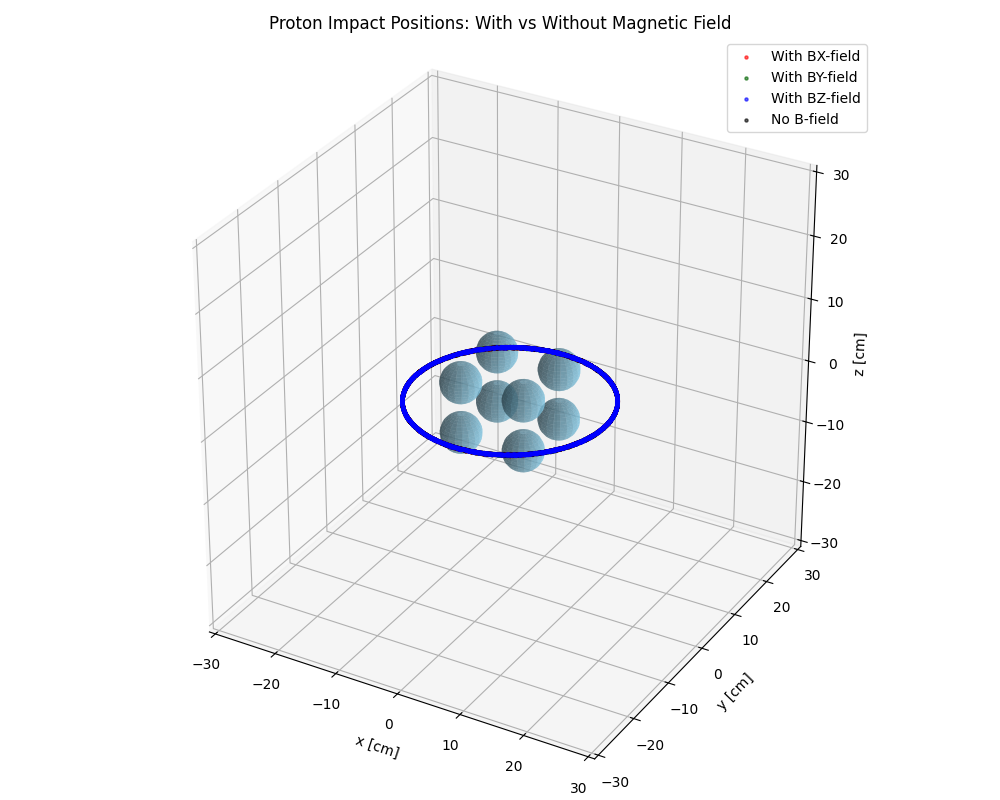

In [49]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw spheres
for cx, cy, cz in centers:
    ax.plot_surface(x_s + cx, y_s + cy, z_s + cz, color='skyblue', alpha=0.6, linewidth=0)

# Plot points with magnetic field
ax.scatter(x_withB, y_withB, z_withB, s=5, c='red', label='With BX-field', alpha=0.6)
ax.scatter(x_withBY, y_withBY, z_withBY, s=5, c='darkgreen', label='With BY-field', alpha=0.6)
ax.scatter(x_withBZ, y_withBZ, z_withBZ, s=5, c='blue', label='With BZ-field', alpha=0.6)

# Plot points without magnetic field
ax.scatter(x_noB, y_noB, z_noB, s=5, c='black', label='No B-field', alpha=0.6)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.set_title('Proton Impact Positions: With vs Without Magnetic Field')
ax.legend()
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Set limits to visualize nicely
lim = 31  # ±6 cm
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)

#for i in range(len(x_withB)):
#    ax.plot(
#        [x_noB[i], x_withBY[i]],
#        [y_noB[i], y_withBY[i]],
#        [z_noB[i], z_withBY[i]],
#        color='gray', alpha=0.3, linewidth=0.5
#    )

plt.tight_layout()
plt.show()

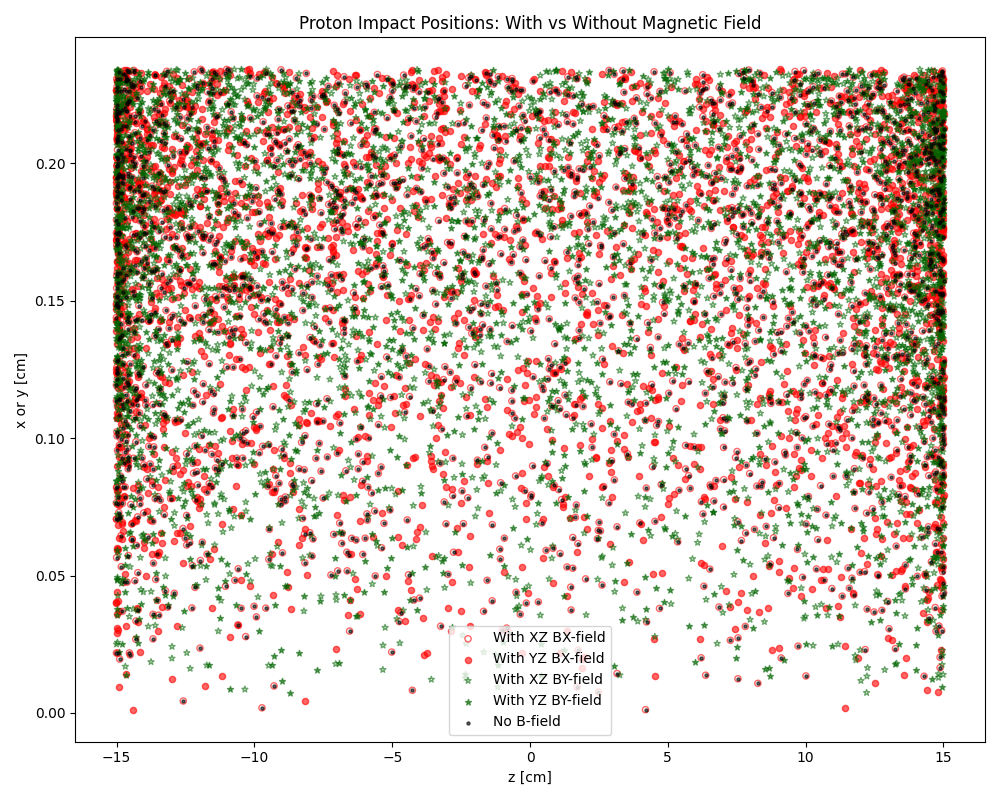

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))


# Draw spheres


# Plot points with magnetic field
ax.scatter(x_withB,  z_withB,  s=20, marker='o', facecolor='none', edgecolor='red', label='With XZ BX-field', alpha=0.6)
ax.scatter(y_withB,  z_withB,  s=20, c='red', marker='o', label='With YZ BX-field', alpha=0.6)
ax.scatter(x_withBY, z_withBY, s=20, marker='*', facecolor='none', edgecolor='darkgreen', label='With XZ BY-field', alpha=0.6)
ax.scatter(y_withBY, z_withBY, s=20, c='darkgreen', marker='*', label='With YZ BY-field', alpha=0.6)

# Plot points without magnetic field
ax.scatter(x_noB,  z_noB, s=5, c='black', label='No B-field', alpha=0.6)

ax.set_xlabel('z [cm]')
ax.set_ylabel('x or y [cm]')
ax.set_title('Proton Impact Positions: With vs Without Magnetic Field')
ax.legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

# Plot points with magnetic field
ax.scatter(x_withB,  z_withB,  s=15, c='red', label='With X BX-field', alpha=0.6)
ax.scatter(y_withB,  z_withB,  s=15, c='darkgreen', label='With Y BY-field', alpha=0.6)

# Plot points without magnetic field
#ax.scatter(x_noB,  z_noB, s=5, c='black', label='No B-field', alpha=0.6)

ax.set_xlabel('x or y [cm]')
ax.set_ylabel('z [cm]')
ax.set_title('Proton Impact Positions: With vs Without Magnetic Field')
ax.legend()

plt.tight_layout()
plt.show()


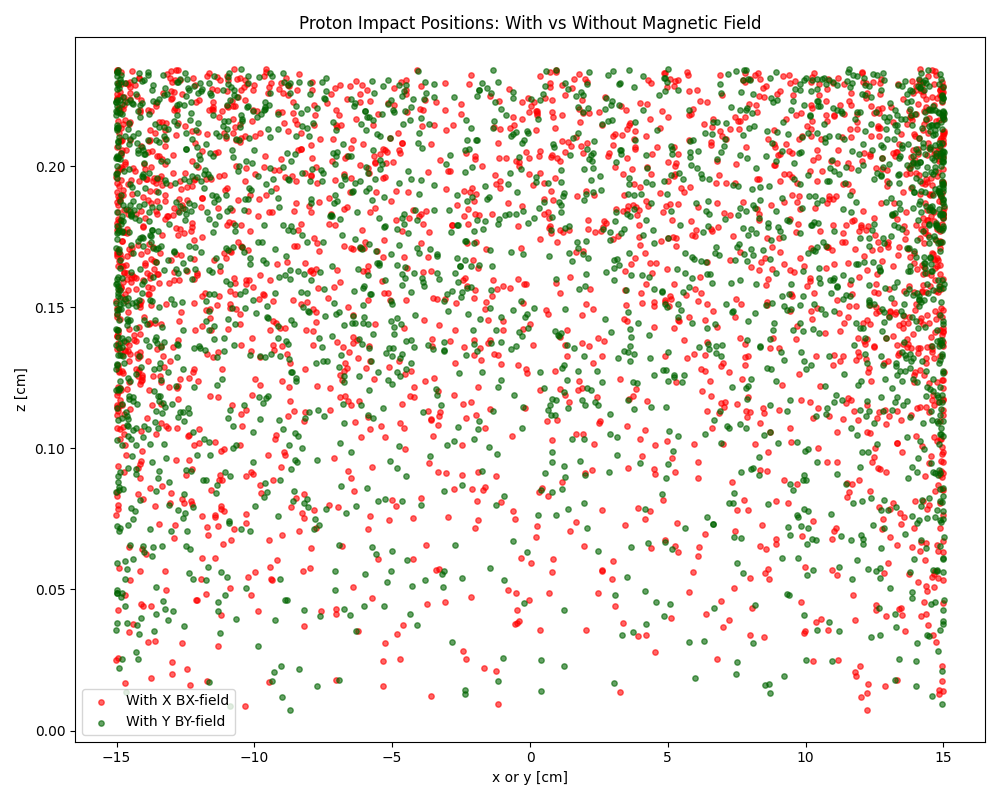

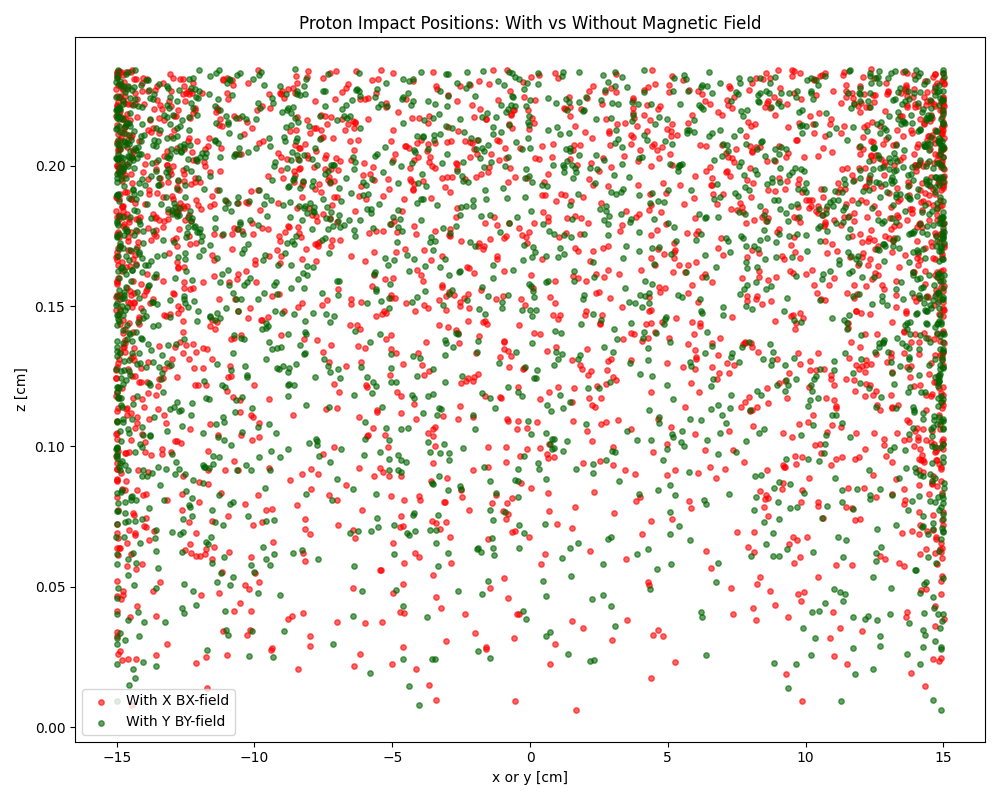

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot points with magnetic field
ax.scatter(x_withBY,  z_withBY,  s=15, c='red', label='With X BX-field', alpha=0.6)
ax.scatter(y_withBY,  z_withBY,  s=15, c='darkgreen', label='With Y BY-field', alpha=0.6)

# Plot points without magnetic field
#ax.scatter(x_noB,  z_noB, s=5, c='black', label='No B-field', alpha=0.6)

ax.set_xlabel('x or y [cm]')
ax.set_ylabel('z [cm]')
ax.set_title('Proton Impact Positions: With vs Without Magnetic Field')
ax.legend()

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 8))

# Plot points with magnetic field
ax.scatter(x_withBZ,  z_withBZ,  s=15, c='red', label='With X BX-field', alpha=0.6)
ax.scatter(y_withBZ,  z_withBZ,  s=15, c='darkgreen', label='With Y BY-field', alpha=0.6)

# Plot points without magnetic field
#ax.scatter(x_noB,  z_noB, s=5, c='black', label='No B-field', alpha=0.6)

ax.set_xlabel('x or y [cm]')
ax.set_ylabel('z [cm]')
ax.set_title('Proton Impact Positions: With vs Without Magnetic Field')
ax.legend()

plt.tight_layout()
plt.show()

# Digitizing the hit positions onto detector pixels/voxels with a given granularity

In [52]:
def digitize(coord, pitch_cm):
    return pitch_cm * np.round(coord / pitch_cm)


## Choose detector granularity

In [53]:
bin_mm = 2.50          # 1 mm detector pitch
bin_cm = bin_mm / 10 # convert to cm

In [54]:
xB_d  = digitize(x_withB,  bin_cm)
yB_d  = digitize(y_withB,  bin_cm)
zB_d  = digitize(z_withB,  bin_cm)

xBY_d = digitize(x_withBY, bin_cm)
yBY_d = digitize(y_withBY, bin_cm)
zBY_d = digitize(z_withBY, bin_cm)

x0_d  = digitize(x_noB,    bin_cm)
z0_d  = digitize(z_noB,    bin_cm)

## Plot digitized hits (2D projections)

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(xB_d,  zB_d,  s=20, facecolor='none', edgecolor='red',
           label='With BX (digitized)', alpha=0.6)

ax.scatter(xBY_d, zBY_d, s=20, marker='*', facecolor='none',
           edgecolor='darkgreen', label='With BY (digitized)', alpha=0.6)

ax.scatter(x0_d,  z0_d,  s=10, c='black',
           label='No B (digitized)', alpha=0.6)

ax.set_xlabel('x [cm]')
ax.set_ylabel('z [cm]')
ax.set_title('Proton Impact Positions ')
ax.legend()

# Add pixel mesh
pitch_cm = bin_cm
#xmin, xmax = ax.get_xlim()
#zmin, zmax = ax.get_ylim()
zmin, zmax = -15, 15 
xmin, xmax = -15, 15 
ax.set_ylim(-5, 5)

for x in np.arange(xmin - pitch_cm/2, xmax + pitch_cm/2, pitch_cm):
    ax.axvline(x, color='gray', lw=0.3, alpha=0.3)

for z in np.arange(zmin - pitch_cm/2, zmax + pitch_cm/2, pitch_cm):
    ax.axhline(z, color='gray', lw=0.3, alpha=0.3)
    
plt.tight_layout()
plt.show()


## True detector-style binning (occupancy map)

In [56]:
xbins = np.arange(xB_d.min(), xB_d.max() + bin_cm, bin_cm)
zbins = np.arange(zB_d.min(), zB_d.max() + bin_cm, bin_cm)

H, xedges, zedges = np.histogram2d(xB_d, zB_d, bins=[xbins, zbins])

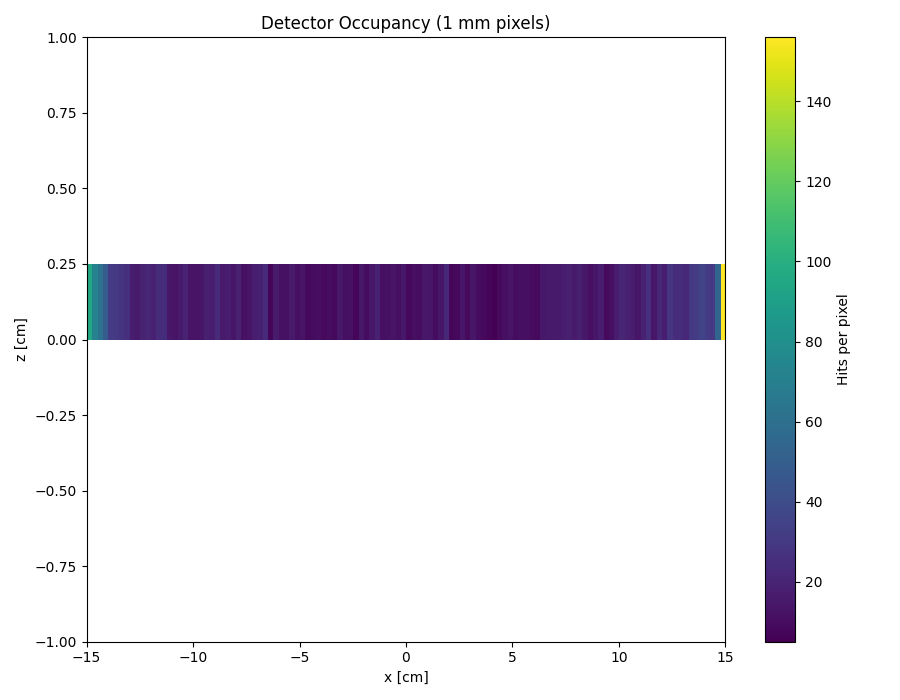

In [57]:
plt.figure(figsize=(9, 7))
plt.imshow(H.T, origin='lower', aspect='auto',
           extent=[xbins[0], xbins[-1], zbins[0], zbins[-1]])
plt.colorbar(label='Hits per pixel')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.ylim(-1, 1)
plt.title('Detector Occupancy (1 mm pixels)')
plt.tight_layout()
plt.show()

## Full 3D voxelization (XYZ detector)

In [58]:
bins_x = np.arange(xB_d.min(), xB_d.max()+bin_cm, bin_cm)
bins_y = np.arange(yB_d.min(), yB_d.max()+bin_cm, bin_cm)
bins_z = np.arange(zB_d.min(), zB_d.max()+bin_cm, bin_cm)

H3D, edges = np.histogramdd(
    np.vstack([xB_d, yB_d, zB_d]).T,
    bins=[bins_x, bins_y, bins_z]
)

## Optional: add resolution smearing

In [59]:
sigma = 0.03  # 300 microns
xB_d += np.random.normal(0, sigma, size=len(xB_d))
zB_d += np.random.normal(0, sigma, size=len(zB_d))